# Simulación de matriz user-ítem

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm

def generate_mask_zipf_global(
    U: int,
    I: int,
    density: float = 0.01,
    alpha_user: float = 1.1,
    alpha_item: float = 1.2,
    seed: int = 0,
    oversample: float = 1.5,
    min_user_ratings: int | None = None,
    min_item_ratings: int | None = None,
):
    """
    Generates ~M unique (u,i) pairs with long-tailed user and item marginals,
    WITHOUT looping over users (for the main sampling).

    - Users: Zipf(alpha_user) then permuted across IDs
    - Items: Zipf(alpha_item) then permuted across IDs
    - Global sampling + dedup to enforce uniqueness of (u,i)

    Optional:
      - min_user_ratings: ensure each user has at least this many interactions
      - min_item_ratings: ensure each item has at least this many interactions

    Note: enforcing minima may increase the final number of pairs beyond M.
    """
    if U <= 0 or I <= 0:
        return []

    if min_user_ratings is not None and min_user_ratings < 0:
        raise ValueError("min_user_ratings must be >= 0 or None.")
    if min_item_ratings is not None and min_item_ratings < 0:
        raise ValueError("min_item_ratings must be >= 0 or None.")
    if min_user_ratings is not None and min_user_ratings > I:
        raise ValueError("min_user_ratings cannot exceed I (unique items per user).")
    if min_item_ratings is not None and min_item_ratings > U:
        raise ValueError("min_item_ratings cannot exceed U (unique users per item).")

    rng = np.random.default_rng(seed)
    M = int(round(density * U * I))
    M = max(0, min(M, U * I))
    if M == 0 and (min_user_ratings is None and min_item_ratings is None):
        return []

    # User probs (Zipf by rank) + permute IDs
    ru = np.arange(1, U + 1, dtype=np.float64)
    pu = ru ** (-alpha_user)
    pu /= pu.sum()
    pu = pu[rng.permutation(U)]

    # Item probs (Zipf by rank) + permute IDs
    ri = np.arange(1, I + 1, dtype=np.float64)
    pi = ri ** (-alpha_item)
    pi /= pi.sum()
    pi = pi[rng.permutation(I)]

    # Collect unique (u,i) pairs via integer keys
    keys = np.empty(0, dtype=np.int64)

    while keys.size < M:
        need = M - keys.size
        batch = int(np.ceil(need * oversample)) + 32

        u = rng.choice(U, size=batch, replace=True, p=pu).astype(np.int64)
        i = rng.choice(I, size=batch, replace=True, p=pi).astype(np.int64)

        k = u * np.int64(I) + i
        keys = np.unique(np.concatenate([keys, k]))

    if keys.size > M:
        keys = rng.choice(keys, size=M, replace=False)

    keys = keys[:M]

    # ---- Enforce minima (may add extra pairs) ----
    if min_user_ratings is not None or min_item_ratings is not None:
        key_set = set(keys.tolist())

        # current degrees
        u0 = (keys // I).astype(np.int64)
        i0 = (keys % I).astype(np.int64)
        user_deg = np.bincount(u0, minlength=U).astype(np.int64)
        item_deg = np.bincount(i0, minlength=I).astype(np.int64)

        def add_pair(uu: int, ii: int):
            kk = int(uu) * int(I) + int(ii)
            if kk in key_set:
                return False
            key_set.add(kk)
            user_deg[uu] += 1
            item_deg[ii] += 1
            return True

        # 1) ensure min per user
        if min_user_ratings is not None:
            for uu in np.where(user_deg < min_user_ratings)[0]:
                need_u = int(min_user_ratings - user_deg[uu])
                tries = 0
                while need_u > 0 and len(key_set) < U * I and tries < 10_000:
                    batch = int(np.ceil(need_u * oversample)) + 32
                    cand_items = rng.choice(I, size=batch, replace=True, p=pi).astype(np.int64)
                    cand_items = np.unique(cand_items)

                    added = 0
                    for ii in cand_items:
                        if add_pair(int(uu), int(ii)):
                            added += 1
                            need_u -= 1
                            if need_u == 0:
                                break
                    if added == 0:
                        tries += 1
                    else:
                        tries = 0  # reset if we made progress

        # 2) ensure min per item
        if min_item_ratings is not None:
            for ii in np.where(item_deg < min_item_ratings)[0]:
                need_i = int(min_item_ratings - item_deg[ii])
                tries = 0
                while need_i > 0 and len(key_set) < U * I and tries < 10_000:
                    batch = int(np.ceil(need_i * oversample)) + 32
                    cand_users = rng.choice(U, size=batch, replace=True, p=pu).astype(np.int64)
                    cand_users = np.unique(cand_users)

                    added = 0
                    for uu in cand_users:
                        if add_pair(int(uu), int(ii)):
                            added += 1
                            need_i -= 1
                            if need_i == 0:
                                break
                    if added == 0:
                        tries += 1
                    else:
                        tries = 0

        # back to arrays
        keys = np.fromiter(key_set, dtype=np.int64)

    u = (keys // I).astype(int)
    i = (keys % I).astype(int)
    return list(zip(u.tolist(), i.tolist()))


In [7]:

def tail_stats(pairs, U, I, top_frac=0.1):
    pairs = np.asarray(pairs, dtype=np.int64)
    u = pairs[:, 0]
    i = pairs[:, 1]

    density = len(pairs) / (U * I)

    user_deg = np.bincount(u, minlength=U)
    item_deg = np.bincount(i, minlength=I)

    def top_share(deg):
        k = max(1, int(round(top_frac * len(deg))))
        return deg[np.argsort(deg)[-k:]].sum() / max(1, deg.sum())

    return {
        "density": density,
        "users_zero": int((user_deg == 0).sum()),
        "items_zero": int((item_deg == 0).sum()),
        f"top{int(top_frac*100)}%_users_share": float(top_share(user_deg)),
        f"top{int(top_frac*100)}%_items_share": float(top_share(item_deg)),
        "max_user_deg": int(user_deg.max()),
        "max_item_deg": int(item_deg.max()),
    }


In [8]:

def fill_ratings_from_mask(
    U: int,
    I: int,
    pairs: list[tuple[int, int]],
    seed: int = 0,
    rating_probs: np.ndarray | None = None,  # probs for [1,2,3,4,5]
    dtype=np.float32,
):
    """
    Returns R (U x I) with NaN for missing and integer ratings 1..5 on masked entries.

    If rating_probs is None -> uniform.
    Else rating_probs must have shape (5,) and sum to 1 (approximately).
    """
    rng = np.random.default_rng(seed)
    R = np.full((U, I), np.nan, dtype=dtype)

    if len(pairs) == 0:
        return R

    u = np.fromiter((p[0] for p in pairs), dtype=np.int64, count=len(pairs))
    i = np.fromiter((p[1] for p in pairs), dtype=np.int64, count=len(pairs))

    # optional safety check
    if (u.min() < 0 or u.max() >= U or i.min() < 0 or i.max() >= I):
        raise ValueError("Some (u,i) indices are out of bounds for shape (U,I).")

    if rating_probs is None:
        r = rng.integers(1, 6, size=len(pairs), dtype=np.int64)  # 1..5
    else:
        rating_probs = np.asarray(rating_probs, dtype=np.float64)
        if rating_probs.shape != (5,):
            raise ValueError("rating_probs must have shape (5,) for ratings 1..5.")
        rating_probs = rating_probs / rating_probs.sum()
        r = rng.choice(np.arange(1, 6), size=len(pairs), p=rating_probs).astype(np.int64)

    # assign (mask is unique in your generator; if not, later duplicates overwrite)
    R[u, i] = r.astype(dtype)
    return R


In [51]:

U, I = 1000, 2000
pairs = generate_mask_zipf_global(
    U, 
    I, 
    density=0.063, 
    alpha_user=0.53, 
    alpha_item=0.7, 
    seed=42, min_user_ratings=20, min_item_ratings=5
)
stats = tail_stats(pairs, U, I, top_frac=0.10)
print(stats)

ratings_matrix = fill_ratings_from_mask(
    U,
    I,
    pairs,
    seed=42,
    rating_probs=[0.05, 0.10, 0.20, 0.35, 0.30],
)


{'density': 0.063, 'users_zero': 0, 'items_zero': 0, 'top10%_users_share': 0.26351587301587304, 'top10%_items_share': 0.35684920634920636, 'max_user_deg': 1100, 'max_item_deg': 837}


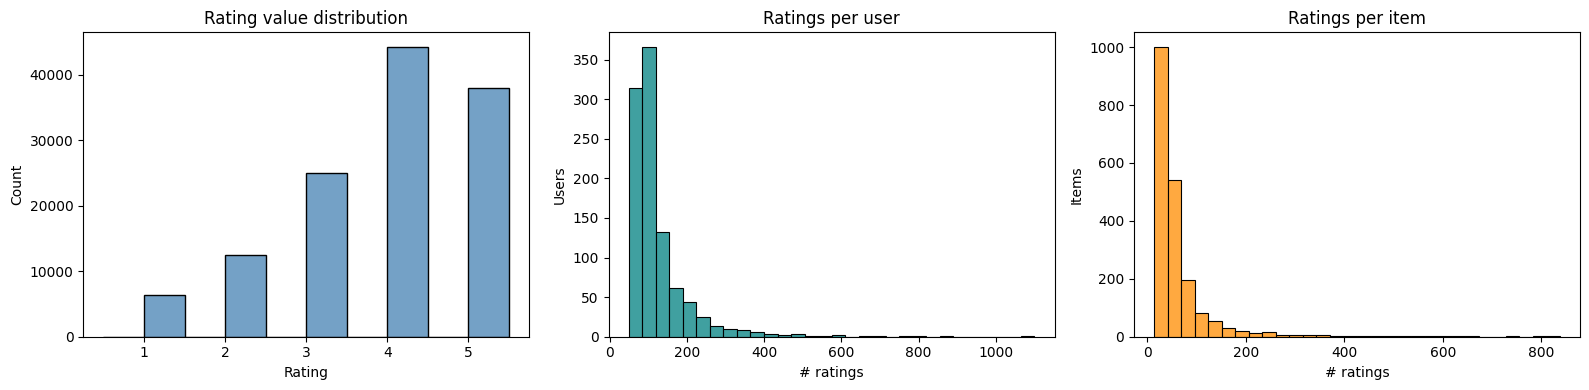

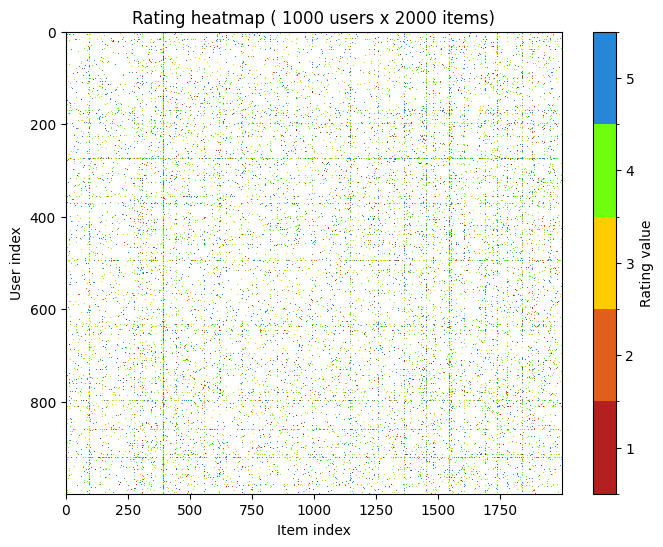

In [52]:
ratings_df = pd.DataFrame(ratings_matrix)

vals = ratings_df.values
mask = ~np.isnan(vals)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.histplot(ratings_df.stack(), bins=np.arange(0.5, 5.6, 0.5), ax=axes[0], color="steelblue")
axes[0].set_title("Rating value distribution")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Count")


user_counts = mask.sum(axis=1)
sns.histplot(user_counts, bins=30, ax=axes[1], color="teal")
axes[1].set_title("Ratings per user")
axes[1].set_xlabel("# ratings")
axes[1].set_ylabel("Users")
# axes[1].set_yscale("log")


item_counts = mask.sum(axis=0)
sns.histplot(item_counts, bins=30, ax=axes[2], color="darkorange")
axes[2].set_title("Ratings per item")
axes[2].set_xlabel("# ratings")
axes[2].set_ylabel("Items")
# axes[2].set_yscale("log")


plt.tight_layout()
plt.show()

# Heatmap with exactly 5 colors (one per rating), NaNs in light gray
plt.figure(figsize=(8, 6))
subset = ratings_df.iloc[:1000, :2000]
subset_vals = subset.to_numpy()
subset_masked = np.ma.masked_invalid(subset_vals)

colors = ["#b41f1f", "#e15f1d", "#ffcc00", "#6eff0e", "#2787d6"]  # 5 distinct colors
cmap = ListedColormap(colors).with_extremes(bad="white")
bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = BoundaryNorm(bounds, cmap.N)

im = plt.imshow(
    subset_masked,
    aspect="auto",
    cmap=cmap,
    norm=norm,
    interpolation="nearest",
)
plt.title("Rating heatmap ( 1000 users x 2000 items)")
plt.xlabel("Item index")
plt.ylabel("User index")
plt.colorbar(im, label="Rating value", ticks=[1, 2, 3, 4, 5])
plt.show()
